# WBCD dataset: Multidimensional reduction comparison between Original and Avatar data and protection metrics evaluation

On this notebook, we present R code to display figures 2b, 3b and 3d  of the article [lien_papier].
The Avatar selected to be compared to the original dataset is the one built on the parameter k = 20.

Two properties of the Avatar method are examined: 
- 1 - Structural similarity observed with an FAMD (Factor Analysis for Mixed Data) projection of an Avatar on the two first components of FAMD of the Original dataset. 
- 2 - Protection level with the computation of local cloaking and hidden rate metrics.

Code regarding feature selection and cancer diagnosis prediction is shown on the Python notebook `messageA_WBCD_python.ipynb`. The F-score and AUROC comparison are presented there.

## Libraries import

In [1]:
# Main libraries
library(tidyverse)
library(reshape2)
library(mice)

# Library to use Python with R
library(reticulate)

# Multidimensionnal reduction method libary
library(FactoMineR)

# Survival analysis libraries
library(survival)
library(survminer)

── Attaching packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.0     ✔ forcats 0.5.1

── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths



Attaching package: ‘mice’


The following object is masked from ‘package:stats’:

    filter


The following objects are masked from ‘package:base’:

    cbind, rbind


Loading required package: ggpubr



In [3]:
# import specific function to compute metrics 
py_run_string("import sys")
py_run_string("sys.path.append('../..')")
py_run_string("from lsg.security_metrics.security_metrics_class import Security_metrics ")
py_run_string("from lsg.dimension.projection import Projection")
py_run_string("from lsg.security_metrics.record_to_avatar_distance import record_to_avatar_distance")
py_run_string("from lsg.security_metrics.local_cloaking import local_cloaking")

## Data loading

In [4]:
data <- read.csv("../../datasets/WBCD/breast_cancer_wisconsin.csv", sep = ",", na.strings = c("NA", "", NA))
data <- data[, -1]
avatar <- read.csv("../../datasets/WBCD/breast_cancer_wisconsin_avatarized_k20.csv", sep = ",", na.strings = c("NA", "", NA))

avatar$Class <- as_factor(avatar$Class)
data$Class <- as_factor(data$Class)

## Graphical parameters

In [5]:
colors <- read.csv("../../color.csv", stringsAsFactors = FALSE)
rownames(colors) <- colors$type

In [6]:
axis_title_size <- 20
axis_text_size <- 20
legend_text_size <- 20
legend_title_size <- 20

## FAMD projection


We are here printing the mutlidimensionnal projection on the two first components of the FAMD (Factor analysis for mixed data).

Individuals are colored by data sources. The original ones are in orange and the avatars in green.

In [7]:
# Merge of datasets 
data_tot <- rbind(data, avatar)

In [8]:
# Perform FAMD with avatar as supplemental indivudals
famd <- FAMD(data_tot, ncp = 5, graph = FALSE, ind.sup = (nrow(data_tot)/2 +1):nrow(data_tot))
res_ind <- as.data.frame(famd$ind$coord)
res_ind_sup <- as.data.frame(famd$ind.sup$coord)
res_ind['type'] <- 'Original'
res_ind_sup['type'] <- 'Avatar'
res_ind_tot <- rbind(res_ind, res_ind_sup)

set.seed(43)
rows <- sample(nrow(res_ind_tot))
res_ind_tot <- res_ind_tot[rows,]

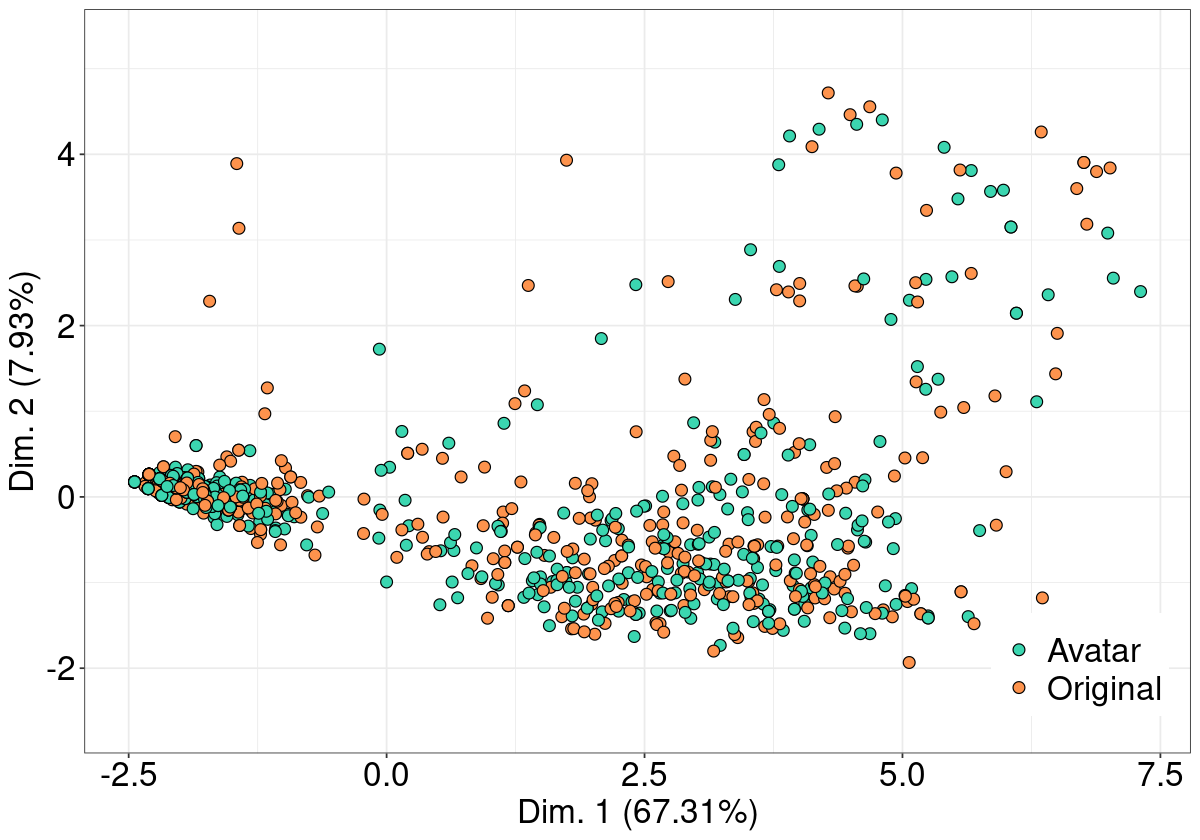

In [9]:
options(repr.plot.width = 10, repr.plot.height = 7)
plot <- ggplot(res_ind_tot, aes(x = Dim.1, y = Dim.2, fill = type)) +
    # add points
    geom_point(size = 3, shape = 21, alpha = 1) +
    # fill according data source
    aes(fill = factor(type)) +
    scale_fill_manual(values = c(colors["avatar","color"], colors["original","color"])) +
    # add axis label with exlplained variability
    xlab(paste0("Dim. 1 (", round(famd$eig[1,2], 2) ,"%)")) +
    ylab(paste0("Dim. 2 (", round(famd$eig[2,2], 2) ,"%)")) +
    ylim(c(-2.6,5.3)) + 
    # theme and figure details
    theme_bw() +
    theme(legend.position = c(0.9, 0.12), 
          legend.title = element_blank(),
          legend.key.size = unit(0.8, "cm"),
          legend.text = element_text(size = legend_text_size, color = "black", family = "sans"),
          axis.text = element_text(size =  axis_text_size, color = "black", family = "sans"),
          axis.title = element_text(size = axis_title_size, color = "black", family = "sans"))

plot

#ggsave(file="../../figure/WBCD_pca_2D.svg", plot=plot, width=10, height=7, dpi = 320)

## Protection level: metrics   

This section provides the computation of protection metrics: local cloaking and hidden rate.

### Local cloaking distribution figure

We first compute metrics, which need the security metrics specifique functions.   
Then, we displayed the distribution of the local cloaking.

In [10]:
metrics <- py$Security_metrics()
metrics$fit(data, avatar, nf = 2L)

In [11]:
df_local_cloaking <- data.frame(metrics$local_cloaking["hit_counts"])
color_vector <- c(rep("#c14f4f", 2), rep(colors['avatar', 'color'], 50))

Warning message:
“Removed 131 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 131 rows containing non-finite values (stat_density).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 131 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 131 rows containing non-finite values (stat_density).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


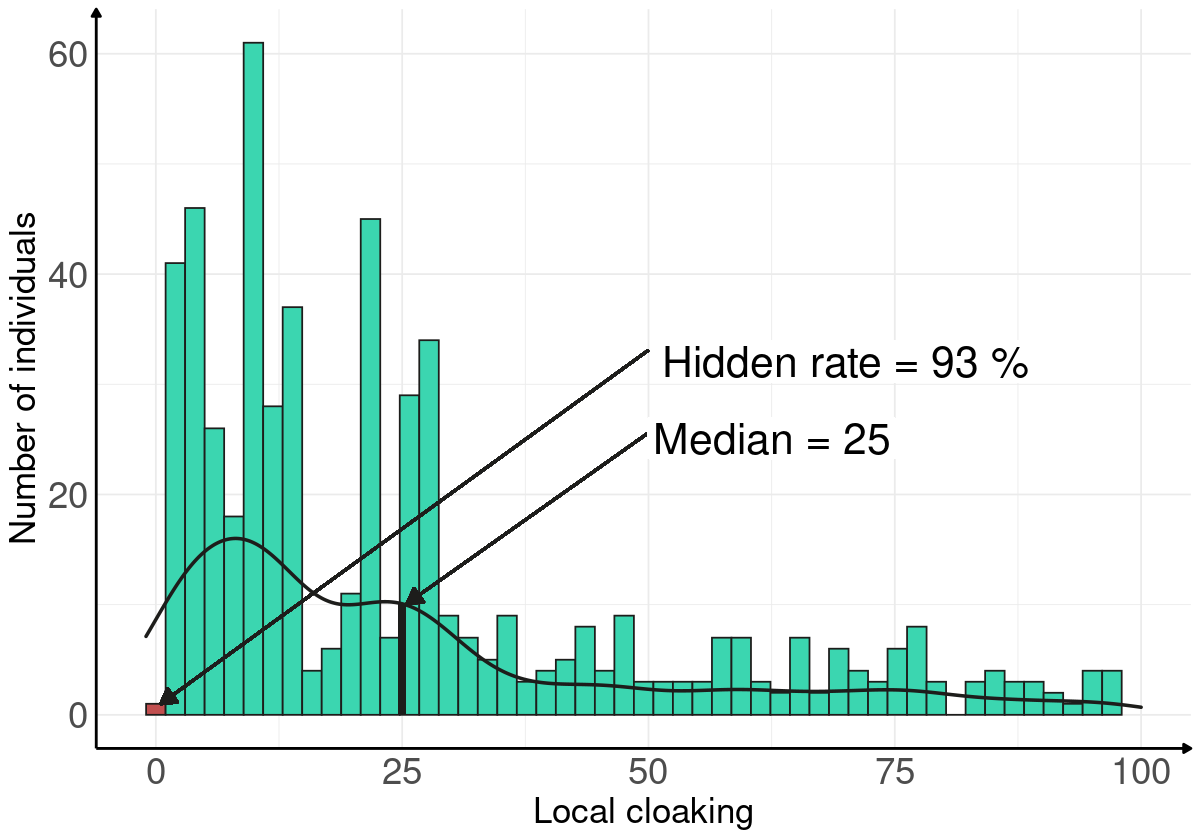

In [12]:
intersect_median_density <- 10.1
options(repr.plot.width = 10, repr.plot.height = 7)


axis_title_size <- 21
axis_text_size <- 22
legend_text_size <- 19
legend_title_size <- 19

plot <- ggplot(df_local_cloaking, aes(hit_counts.1)) +
    # add histogram and density
    geom_histogram(bins = 52, fill = color_vector, 
                   color = "#1D1D1B") +
    geom_density(aes(y = ..count..), lwd = 1, color = "#1D1D1B") +
    # theme and axis
    xlim(c(-1,100)) +
    theme_minimal() +
    xlab("Local cloaking") +
    ylab("Number of individuals") +
    theme(axis.title = element_text(size = axis_title_size, family = "sans"),
          axis.text = element_text(size = axis_text_size, family = "sans"),
          axis.line = element_line(colour = "black", 
                                   size = 0.8, 
                                   linetype = "solid", 
                                   arrow = arrow(type='closed', length = unit(5,'pt')))) +

    ## add arrow and text 
    # median segment
    geom_segment(aes(x = median(hit_counts.1),
                     y = 0, 
                     xend = median(hit_counts.1),
                     yend = intersect_median_density), 
                 color = '#1D1D1B', size = 2) +

    # median arrow and text
    geom_segment(aes(x = median(hit_counts.1) + 25,
                     y = intersect_median_density + 15.5, 
                     xend = median(hit_counts.1) + 0.5,
                     yend = intersect_median_density ), 
                 color = '#1D1D1B', size = 0.8, 
                 arrow = arrow(type='closed', length = unit(10, 'pt'))) +
    geom_label(aes(x =  median(hit_counts.1) + 37.5, 
                   y =  intersect_median_density + 15,
                   label =paste0("Median = ", median(hit_counts.1))), 
               size = 9, 
               family = "sans", 
               label.size = NA) + 

    # hidden rate arrow and text 
    geom_segment(aes(x = median(hit_counts.1) + 25, 
                     y = intersect_median_density + 23, 
                     xend = 0.5, 
                     yend = sum(df_local_cloaking[,1] == 0) ), 
                 color = '#1D1D1B', size = 0.8, 
                 arrow = arrow(type='closed', length = unit(10,'pt'))) +
    geom_label(aes(x =  median(hit_counts.1) + 45, 
                   y = intersect_median_density + 22,
                   label = paste0("Hidden rate = ", round(metrics$hidden_rate, 0), " %")), 
               size = 9, 
               family = "sans", 
               label.size = NA) +
    
    scale_color_manual(name = "statistics", values = c(median = "red"))


plot 

ggsave(file="../../figure/WBCD_local_cloaking.svg", plot=plot, width=10, height=7, dpi = 320)

In [16]:
# Number of individuals with a local cloaking under 5
sum( df_local_cloaking$hit_counts.1 < 5) / dim( df_local_cloaking )[1] *100

[1] 12.88433

###  Zero cloaking over 25 avatarizations

To test the protection level of the Avatar method, we computed 25 avatars with k = 20 and looked at the number time that local clocking is equal to 0.

In [13]:
avatar_tot <- read.csv('../../datasets/WBCD/wbcd_avatarized_25time_k20_nf_2.csv')
avatar_tot["Class"] <- lapply(avatar_tot["Class"], factor)
pr <- py$Projection()
coord_original <- pr$fit_transform(data, nf = 2L)[[1]]

In [14]:
df_local_cloaking_k2 <- data.frame(row.names = 1:nrow(data))
for (k in unique(avatar_tot$iter)) {
    avatar <- avatar_tot[avatar_tot$iter == k,]
    coord_avatar <- pr$transform(avatar[, 1:(ncol(avatar) - 1)])
    distances <- py$record_to_avatar_distance(coord_original, coord_avatar)
    local_cloaking <- py$local_cloaking(coord_original, coord_avatar, distances)
    df_local_cloaking_k2[paste0("local_cloaking_", k)] <- local_cloaking$hit_counts[, 1]
}

In [15]:
df_local_cloaking_k2_LC0 <- as.data.frame(table(rowSums(df_local_cloaking_k2 == 0)))
df_local_cloaking_k2_LC0["Freq2"] <- paste0(formatC(df_local_cloaking_k2_LC0$Freq/sum(df_local_cloaking_k2_LC0$Freq)*100, format = "f", digits = 1), "%")

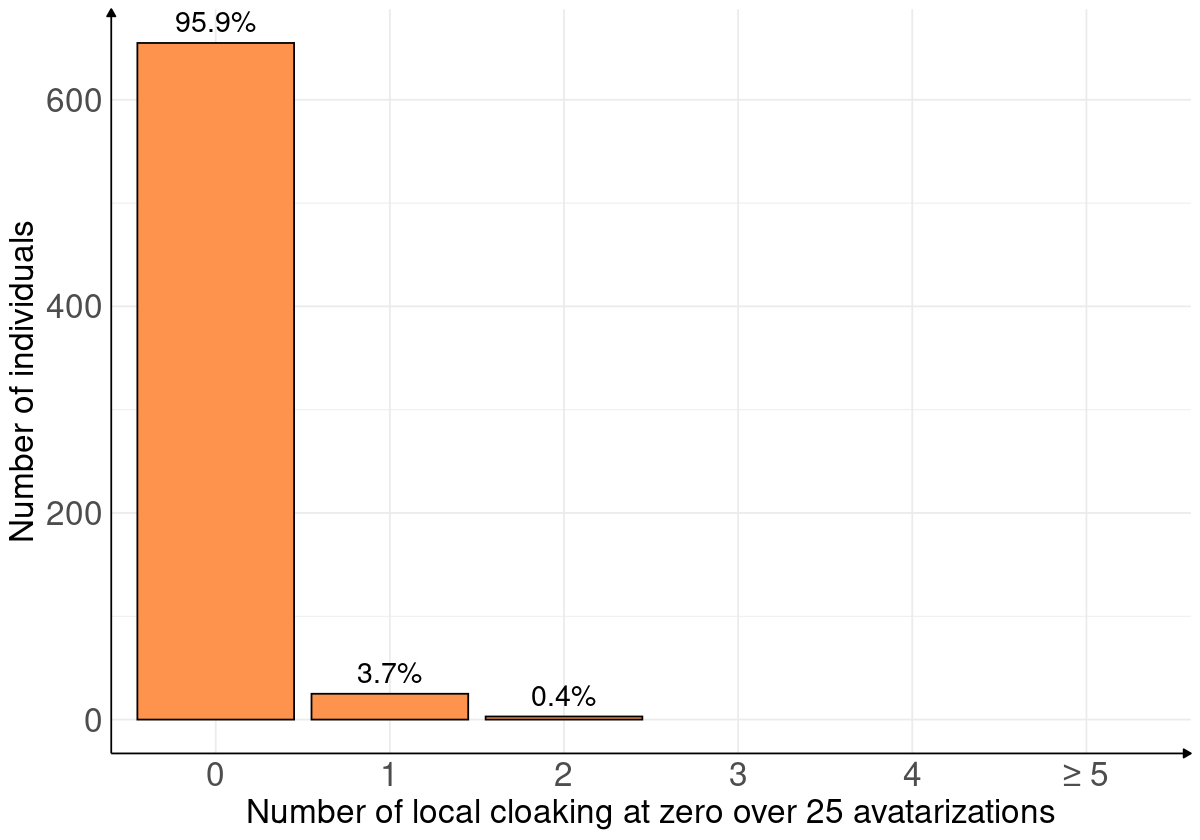

In [26]:
options(repr.plot.width = 10, repr.plot.height = 7)
plot <- ggplot(df_local_cloaking_k2_LC0, aes(x = Var1, y = Freq)) +
    # histogram
    geom_bar(fill = colors["original", "color"], colour = "black", show.legend = FALSE, stat = "identity") + 
    # adding percentage as text on each bar
    geom_text(aes(label = sprintf('%.1f%%', after_stat(df_local_cloaking_k2_LC0$Freq / sum(df_local_cloaking_k2_LC0$Freq) * 100))),
              vjust = -0.5, size = 6) +
    # axis and theme 
    ylab("Number of individuals") + 
    xlab("Number of local cloaking at zero over 25 avatarizations") +
    theme_minimal() +
    theme(axis.title = element_text(size = axis_title_size, family = "sans"),
          axis.text = element_text(size = axis_text_size, family = "sans"),
          axis.line = element_line(colour = "black", 
                                   size = 0.5, 
                                   linetype = "solid", 
                                   arrow = arrow(type = 'closed', length = unit(5,'pt')))) +
    scale_x_discrete(breaks = c("0", "1", "2", "3", "4", "\U2265 5"), limits = c("0", "1", "2", "3", "4", "\U2265 5"))

plot 

#ggsave(file="../../figure/WBCD_zeroCloaking_percentage.svg", plot=plot, width=10, height=7, dpi = 320)